## Baseline using Ridge Regression

In [89]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sumy import evaluation
from sumy.models import dom
from sumy.nlp import tokenizers
from stemming.porter2 import stem
from os import listdir
import os.path
from nltk.corpus import stopwords
import nltk
import copy
import pickle
import unicodedata
import re
import numpy as np
import operator
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk.data

java_path = "C:/Program Files/Java/jdk1.7.0_71/bin/java.exe"
os.environ['JAVAHOME'] = java_path
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
%matplotlib inline

<b> Feature Extraction:

 <img src=".\Others\Features.png" alt="HTML5 Icon" width="800" height="500", style="display: ;">

In [2]:
data_root_dir = '..\data\DUC2001'
annotation_file = 'annotations.txt'
txt_opn_tag = '<TEXT>'
txt_close_tag = '</TEXT>'

In [3]:
def get_cluster_and_its_files(data_root_dir,annotation_file):
    '''Get a Cluster and the file names associated with it
       Returns a dictionary of the form { cluster_1 : [file1,file2,file3....], cluster_2 : [file1,file2,file3....] }'''    
    
    f = open(data_root_dir + '\\' + annotation_file,'r')
    
    clust_files = defaultdict(list)
    
    
    for line in f.readlines():
        cur_line = line.split(';')[0]
        clust_name = cur_line.split('@')[1]
        file_name = cur_line.split('@')[0]
        
        clust_files[clust_name].append(file_name)
        
    f.close()
    
    return clust_files
    
        

In [4]:
clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
print clust_files['mad cow disease']
clust_list = clust_files.keys()

['AP900322-0200', 'FBIS-41815', 'FBIS-45908', 'FT921-9310', 'FT931-3883', 'FT933-8272', 'FT941-575', 'LA042290-0104', 'LA060490-0083', 'WSJ910107-0139']


In [5]:
def get_text_from_doc(document_path,txt_opn_tag,txt_close_tag):
    
    f = open(document_path,'r')
    content = f.read()
    f.close()
    
    start = content.index(txt_opn_tag) + len(txt_opn_tag)
    end   = content.index(txt_close_tag)
    
    return content[start:end]
        

In [6]:
def tokenize_txt(text,nltk_flag=True,ner_flag=False):
    
    text = text.strip()
    
    if ner_flag == True:        
        tokenizedList = re.split('[^a-zA-Z]+', text.lower())
        return tokenizedList
    
    if nltk_flag == False:
        #return [x.lower() for x in re.findall(r"\w+", text)]

        tokenizedList = re.split('\W+', text.lower())
        return [unicode(x,'utf-8') for x in tokenizedList if x != '' and x != '\n' and x != u'\x85' and x != '\r' and x != '_']
    else:
        return nltk.word_tokenize(unicode(text,'utf-8')) 
        #return [x for x in toks if x != '' and x != '\n' and x != u'\x85' and x != '\r' and x != '_' and x!= ',' and x != '.']    
    

In [7]:
tokenize_txt('What is this ?? Is this _ cool ? I don\'t know',nltk_flag=True,ner_flag=True)

['what', 'is', 'this', 'is', 'this', 'cool', 'i', 'don', 't', 'know']

<b>Feature 1 : Term frequency over the cluster(TF)

In [8]:
def get_term_freqs(data_root_dir,annotation_file,stop_words=None) :
    '''Get the term freqs of words in clusters. The term freqs are unique to clusters.
    Returns a dict of form {clust1 : {word1 : 2, word2 :3...},clust2 : {word1 : 2, word2 :3..} ......}'''
        
    #Check about stop_words
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_term_freq = defaultdict(defaultdict)
    
    
    for clust,files in clust_files.iteritems():
        term_freq = defaultdict(int)
        
        for doc in files:
            doc_path = data_root_dir + '\\' + doc
            txt = get_text_from_doc(doc_path,txt_opn_tag,txt_close_tag)
            doc_tokens = tokenize_txt(txt)
            
            for token in doc_tokens:
                term_freq[token] += 1
        
        clust_term_freq[clust] = term_freq
    
    return clust_term_freq
            
            
            
    

In [9]:
clust_word_tfs = get_term_freqs(data_root_dir,annotation_file)
print clust_word_tfs['cattle disease']

defaultdict(<type 'int'>, {u'all': 1, u'Union': 1, u'Kretzschmar': 1, u'Switzerland': 1, u'per': 1, u'human': 1, u'still': 1, u'decisions': 1, u'its': 1, u'European': 1, u'Jakob': 1, u'one': 1, u'March': 1, u'(': 2, u'had': 2, u',': 10, u'should': 1, u'to': 6, u'safeguards': 1, u'do': 1, u'popularly': 1, u'affected': 1, u'diseases': 1, u'than': 1, u'government': 1, u'very': 1, u'100,000': 1, u'scientists': 1, u'possible': 1, u'Gottingen': 1, u'were': 3, u'know': 1, u'not': 3, u'affect': 2, u'existing': 1, u'countries': 1, u'medicines': 1, u'50': 1, u'whether': 1, u'transmitted': 2, u'minimal': 1, u'ban': 2, u'Contaminated': 1, u'because': 1, u'humans': 4, u'bovine': 1, u'connections': 1, u'likely': 1, u'catching': 1, u'are': 1, u'encephalopathy': 1, u'further': 1, u'institutes': 1, u'agriculture': 1, u'concern': 1, u'universities': 1, u'project': 1, u'said': 3, u'imported': 3, u'for': 2, u'1992': 1, u'recorded': 1, u'expressed': 1, u'research': 4, u'I': 1, u'health': 1, u'between': 1, 

<b> Feature 2 : Total document number in the datasets, divided by the frequency of documents which contains this word (IDF)

In [10]:
def get_doc_freqs(data_root_dir,annotation_file):
    
    '''Return a dictionary of the form {word1 : df1 , word2 : df2 ...}'''
    '''Example : {furazabol : 154.5 , the : 1.00032}'''
    
    data_root_dir += '\\'
    
    docs =  [file_name for _,__,file_name in os.walk(data_root_dir)][0]
    
    if annotation_file in docs:
        docs.remove(annotation_file)        
    
    inverted_index  = defaultdict(set)
    
    
    for doc in docs:
        doc_path = data_root_dir + doc        
        txt = get_text_from_doc(doc_path,txt_opn_tag,txt_close_tag)
        doc_tokens = tokenize_txt(txt)
        
        for token in doc_tokens:
            inverted_index[token].add(doc)
    
    
    
    no_of_docs = len(docs)
    idf_dict = defaultdict(float)
    
    for term,doc_lst in inverted_index.iteritems():
        idf_dict[term] = float(no_of_docs) / len(doc_lst)
    
    return idf_dict
        
        
    

In [11]:
doc_freqs = get_doc_freqs(data_root_dir,annotation_file)
print doc_freqs['furazabol']
print doc_freqs['the']

154.5
1.00324675325


<b>Feature 3 : The frequency of documents which contains this word in the current cluster (CF)

In [12]:
def get_clusterwise_dfs(data_root_dir,annotation_file):
    
    '''Return a dictionary of the form : {clust1 : (word1 : df1,word2 :df2 .....) , clust1 : (word3 : df3,word2 :df3 .....)}'''
    '''Note that the document frequencies of term are calculated clusterwise, and not on the whole dataset'''
    
    clust_doc_freqs = defaultdict(defaultdict)
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    for clust,files in clust_files.iteritems():
        inverted_index  = defaultdict(set)
        
        for doc in files:
            doc_path = data_root_dir + '\\' + doc
            txt = get_text_from_doc(doc_path,txt_opn_tag,txt_close_tag)
            doc_tokens = tokenize_txt(txt)
            
            for token in doc_tokens:
                inverted_index[token].add(doc)
        
        
        clust_df = defaultdict(int)
        
        for term,doc_lst in inverted_index.iteritems():
            clust_df[term] =  len(doc_lst)
        
        clust_doc_freqs[clust] = clust_df
    
    return clust_doc_freqs

In [13]:
clust_dfs = get_clusterwise_dfs(data_root_dir,annotation_file)
print sorted(clust_dfs['mad cow disease'].items(),key=operator.itemgetter(1),reverse=True)[0:20]

[(u',', 10), (u'encephalopathy', 10), (u'cow', 10), (u'and', 10), (u'.', 10), (u'in', 10), (u'the', 10), (u'has', 10), (u'for', 10), (u"'s", 10), (u'that', 10), (u'were', 10), (u'spongiform', 10), (u'of', 10), (u'with', 10), (u'as', 10), (u'to', 10), (u'a', 10), (u'be', 10), (u'from', 10)]


<b>Feature 4 : A 4-dimension binary vector indicates whether the word is a noun, a verb, an adjective or an adverb. If the word has
another part-of-speech, the vector is all-zero  (POS)

In [14]:
def get_short_tag(long_tag,valid_pos=['NN','VB','JJ','RB']):      
    '''Truncate long_tag to get its first 2 chars. If a valid POS, return first 2 chars. else return OT (Other)'''
    '''Valid POS are NN,VB,JJ,RB'''
    
    valid_pos_lst = valid_pos
       
    long_tag = str.upper(long_tag[0:2])
    
    if long_tag in valid_pos_lst:
        return long_tag
    
    else:
        return 'OT'                

In [15]:
def get_sentence_tags(sentence):
    '''POS tag the words in the sentence and return a dict of the form : {word1 : [tag1,tag2..], word2 : [tag3,tag4..]..}'''
    word_tag_dict = defaultdict(set)
    #sent_tags = pos_tagger.tag(tokenize_txt(sentence))
    sent_tags = nltk.pos_tag(tokenize_txt(sentence))
        
    for word_tag in sent_tags:
        word = word_tag[0]
        tag = word_tag[1]
        
        word_tag_dict[word].add(get_short_tag(tag))
    
    return word_tag_dict

In [16]:
print get_sentence_tags("sent one")
print get_sentence_tags("sent two")

defaultdict(<type 'set'>, {u'sent': set(['VB']), u'one': set(['OT'])})
defaultdict(<type 'set'>, {u'two': set(['OT']), u'sent': set(['NN'])})


In [17]:
def get_doc_tags(document):
    
    '''Perform POS tagging on all the sentences in the document and return a dict of the form :'''
    ''' (sent_id : { word1 : tag1 ...}...}'''
    
    sent_and_tags = defaultdict(int)
    
    #sentences = document.split('.')
    sentences = sent_detector.tokenize(document,realign_boundaries=True)
    
    for i,sentence in enumerate(sentences):
        sent_and_tags[i] = get_sentence_tags(sentence.strip('.').strip('\n'.strip('')))
    
    return sent_and_tags

In [18]:
get_doc_tags("Who is Alan Turing ??. Alan was born in the United Kingdom")

defaultdict(<type 'int'>, {0: defaultdict(<type 'set'>, {u'Turing': set(['NN']), u'is': set(['VB']), u'Who': set(['OT']), u'?': set(['OT']), u'Alan': set(['NN'])}), 1: defaultdict(<type 'set'>, {u'Kingdom': set(['NN']), u'United': set(['NN']), u'Alan': set(['NN']), u'born': set(['VB']), u'in': set(['OT']), u'the': set(['OT']), u'was': set(['VB'])})})

In [21]:
def get_cluster_tags(data_root_dir,annotation_file):
    '''Perfom Part of Speech Tagging across all the sentences in all the documents in all the clusters'''
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_tags = defaultdict(defaultdict)
    
    i = 1
    for clust,files in clust_files.iteritems():        
        
        for doc in files:
            
            if i %10 == 0:
                print 'Finished tagging doc :', i
            i += 1
            doc_path = data_root_dir + '\\' + doc
            txt = get_text_from_doc(doc_path,txt_opn_tag,txt_close_tag)
            
            clust_tags[clust][doc] = get_doc_tags(txt)
            
    return clust_tags

In [22]:
clust_tags = get_cluster_tags(data_root_dir,annotation_file)

In [24]:
def deserialize(file_name):

    with open(file_name, 'rb') as f:
        return pickle.load(f)
    

In [25]:
file_name = 'pos_tags.pickle'
#serialize(file_name,clust_tags)
clust_tags = deserialize(file_name)
print 'done'

done


In [26]:
old_cpy = copy.deepcopy(clust_tags)

In [27]:
def vectorize_pos(pos_set,pos_idx = {'NN' : 0 ,'VB' : 1,'JJ' : 2,'RB' : 3}):
    
    '''Convert the POS set to a binary vector according to pos_idx'''    
    bin_pos_vec = 4*[False]
    
    for pos in pos_set:
        
        if pos == 'OT':
            return 4*[False]
        else:
            bin_pos_vec[pos_idx[pos]] = True
    
    return bin_pos_vec

In [28]:
print vectorize_pos({'NN','RB'})
print vectorize_pos({'NN','RB','JJ','VB','OT'})

[True, False, False, True]
[False, False, False, False]


In [29]:
def vectorize_tags_across_clusters(clust_tags):
    '''Binarize the POS of words'''

    for clust,doc in clust_tags.iteritems(): 

        doc_sent = defaultdict(defaultdict)

        for doc,sent in doc.iteritems():

            sent_word = defaultdict(defaultdict)

            for sen_id,word_pos in sent.iteritems():


                for word,pos in word_pos.iteritems():                            
                    word_pos[word] = copy.deepcopy(vectorize_pos(pos))

                sent_word[sen_id] = copy.deepcopy(word_pos)

            doc_sent[doc] = copy.deepcopy(sent_word)

        clust_tags[clust] = copy.deepcopy(doc_sent)

    return clust_tags


In [30]:
new_clust_tags = vectorize_tags_across_clusters(clust_tags)

In [31]:
print old_cpy['mad cow disease']['LA060490-0083'][2],'\n\n'
print new_clust_tags['mad cow disease']['LA060490-0083'][2]

defaultdict(<type 'set'>, {'and': set(['OT']), 'humans': set(['NN']), 'sales': set(['NN']), 'topic': set(['NN']), 'put': set(['VB']), 'britain': set(['NN']), 'in': set(['OT']), 'subject': set(['NN']), 'beef': set(['NN']), 'to': set(['OT']), 'crimp': set(['NN']), 'has': set(['VB']), 'be': set(['VB']), 'that': set(['OT']), 'domestic': set(['JJ']), 'pubs': set(['NN']), 'press': set(['NN']), 'a': set(['OT']), 'made': set(['VB']), 'concern': set(['NN']), 'of': set(['OT']), 'disease': set(['NN']), 'p': set(['NN']), 'transmitted': set(['VB']), 'can': set(['OT']), 'serious': set(['JJ']), 'the': set(['OT'])}) 


defaultdict(<type 'set'>, {'and': [False, False, False, False], 'humans': [True, False, False, False], 'sales': [True, False, False, False], 'topic': [True, False, False, False], 'put': [False, True, False, False], 'britain': [True, False, False, False], 'in': [False, False, False, False], 'subject': [True, False, False, False], 'beef': [True, False, False, False], 'to': [False, False, 

<b>Feature 5 : A binary value equals one iff the output of the named entity classifier from CoreNLP is not empty  (Named Entity)

In [32]:
def extract_ners(data_root_dir,annotation_file):
    '''Perform Named Entity Recognition on all sentences in all docs in all clusters'''
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_doc = defaultdict(defaultdict)
    
    for clust,files in clust_files.iteritems():    
        
        doc_sent = defaultdict(defaultdict)
        
        for file_name in files:            
            
            
            file_path = data_root_dir + '\\' + file_name
            doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
            sentences = sent_detector.tokenize(doc)
            sent_tokens =[tokenize_txt(sent,nltk_flag=True,ner_flag=True) for sent in sentences]
            
            sent_ner_cnt = defaultdict(int)
            
            for s_id,tok_sent in enumerate(sent_tokens):    
                
                
                ners = ner_tagger.tag(tok_sent)
                cnt = 0
                for ner in ners:
                    if ner[1] != 'O':
                        cnt += 1
                sent_ner_cnt[s_id] = cnt
            
            doc_sent[file_name] = copy.deepcopy(sent_ner_cnt)
            
            print 'FINISHED NER ON ', file_name
        clust_doc[clust] = copy.deepcopy(doc_sent)
        
    return clust_doc

In [33]:
file_name = 'ner_tags.pickle'
#serialize(file_name,clust_ners)
clust_ners = deserialize(file_name)
print 'done'

done


In [34]:
clust_ners['mad cow disease']['LA060490-0083']

defaultdict(<type 'int'>, {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1, 10: 0, 11: 2, 12: 1, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 2, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 0})

<b>Feature 6 : A binary value denotes if a word in Number  (Number)</b>

In [35]:
def extract_digit_cnt(data_root_dir,annotation_file,cnt_ratio_flag='C'):
    '''Count the number of digits in a sentence'''
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_doc = defaultdict(defaultdict)
    
    for clust,files in clust_files.iteritems():    
        
        doc_sent = defaultdict(defaultdict)
        
        for file_name in files:            
            
            
            file_path = data_root_dir + '\\' + file_name
            doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
            sentences = sent_detector.tokenize(doc)
            sent_tokens =[tokenize_txt(sent) for sent in sentences]
            
            sent_dig_cnt = defaultdict(int)
            
            dig_cnt = 0
            for s_id,tok_sent in enumerate(sent_tokens):                                    
                for tok in tok_sent:
                    if tok.isdigit():
                        dig_cnt += 1
                if cnt_ratio_flag == 'C':
                    sent_dig_cnt[s_id] = dig_cnt
                else:
                    sent_dig_cnt[s_id] = float(dig_cnt)/len(tok_sent)
        
            doc_sent[file_name] = copy.deepcopy(sent_dig_cnt)            
        
        clust_doc[clust] = copy.deepcopy(doc_sent)        
        
    return clust_doc

In [36]:
clust_digs = extract_digit_cnt(data_root_dir,annotation_file)
print 'done'

done


In [37]:
print clust_digs['mad cow disease']['LA060490-0083'][29]

3


<b>Feature 22 : The number of digits, divided by the sentence length(Number ratio)

In [38]:
clust_dig_ratio = extract_digit_cnt(data_root_dir,annotation_file,'R')
print 'done'
clust_dig_ratio['mad cow disease']['LA060490-0083']

done


defaultdict(<type 'int'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.03225806451612903, 9: 0.2, 10: 0.06451612903225806, 11: 0.10526315789473684, 12: 0.08333333333333333, 13: 0.07142857142857142, 14: 0.1111111111111111, 15: 0.2, 16: 0.09090909090909091, 17: 0.2222222222222222, 18: 0.07142857142857142, 19: 0.06666666666666667, 20: 0.10714285714285714, 21: 0.125, 22: 1.0, 23: 0.10714285714285714, 24: 0.1875, 25: 0.12, 26: 0.3333333333333333, 27: 0.21428571428571427, 28: 0.10714285714285714, 29: 1.0})

<b>Feature 23 : The number of stop words, divided by the sentence length(Stop word ratio)

In [39]:
def stop_word_ratio(data_root_dir,annotation_file):
    '''Compute the stop word ratio for all sentences'''
    '''stop word ratio == no of stop words in sent / len(sent) '''
    
    english_stopwords = set(stopwords.words('english'))
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_doc = defaultdict(defaultdict)
    
    for clust,files in clust_files.iteritems():    
        
        doc_sent = defaultdict(defaultdict)
        
        for file_name in files:            
            
            
            file_path = data_root_dir + '\\' + file_name
            doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
            sentences = sent_detector.tokenize(doc)
            sent_tokens =[tokenize_txt(sent) for sent in sentences]
            
            sent_dig_cnt = defaultdict(int)
            
            
            for s_id,tok_sent in enumerate(sent_tokens):      
                stop_cnt = 0
                for tok in tok_sent:
                    if tok.lower() in english_stopwords:
                        stop_cnt += 1
                sent_dig_cnt[s_id] = float(stop_cnt)/len(tok_sent)
        
            doc_sent[file_name] = copy.deepcopy(sent_dig_cnt)            
        
        clust_doc[clust] = copy.deepcopy(doc_sent)        
        
    return clust_doc

In [40]:
clust_stop_word_ratio = stop_word_ratio(data_root_dir,annotation_file)
print 'done'
print clust_stop_word_ratio['mad cow disease']['LA060490-0083'][18]

done
0.392857142857


<b>Feature 24 : No of words in the sentence (Sentence Length)

In [41]:
def sent_length(data_root_dir,annotation_file):
    '''Compute the Lenght of sentences and store them in a dictionary'''    
        
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_doc = defaultdict(defaultdict)
    
    for clust,files in clust_files.iteritems():    
        
        doc_sent = defaultdict(defaultdict)
        
        for file_name in files:            
            
            
            file_path = data_root_dir + '\\' + file_name
            doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
            sentences = sent_detector.tokenize(doc)
            sent_tokens =[tokenize_txt(sent) for sent in sentences]
            
            sent_dig_cnt = defaultdict(int)
            
            
            for s_id,tok_sent in enumerate(sent_tokens):      
                sent_dig_cnt[s_id] = len(tok_sent)
        
            doc_sent[file_name] = copy.deepcopy(sent_dig_cnt)            
        
        clust_doc[clust] = copy.deepcopy(doc_sent)        
        
    return clust_doc

In [42]:
clust_sent_lens = sent_length(data_root_dir,annotation_file)
print 'done'
print clust_sent_lens['mad cow disease']['LA060490-0083'][15]

done
10


In [43]:
file_path = data_root_dir + '\\' + 'LA060490-0083'
doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
sentences = sent_detector.tokenize(doc)
print len(sentences[15].split(' '))

9


<b>Feature 21 : The number of named entities divided by sentence length (NER Ratio)

In [44]:
def ner_ratio(data_root_dir,annotation_file,clust_ners,clust_sent_lens):
    '''Compute the Ratio of NERS : Sentence lenght and store them in a dictionary'''            
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_doc = defaultdict(defaultdict)
    
    for clust,files in clust_files.iteritems():    
        
        doc_sent = defaultdict(defaultdict)
        
        for file_name in files:            
            
            
            file_path = data_root_dir + '\\' + file_name
            doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
            total_sents = len(sent_detector.tokenize(doc))
            #sent_tokens =[tokenize_txt(sent) for sent in sentences]
            
            sent_ner_ratio = defaultdict(int)
            
            
            for i in range(0,total_sents):
                sent_ner_ratio[i] = float(clust_ners[clust][file_name][i])/clust_sent_lens[clust][file_name][i]
                        
        
            doc_sent[file_name] = copy.deepcopy(sent_ner_ratio)            
        
        clust_doc[clust] = copy.deepcopy(doc_sent)        
        
    return clust_doc

In [45]:
clust_ner_ratio = ner_ratio(data_root_dir,annotation_file,clust_ners,clust_sent_lens)
print 'done'
print clust_ner_ratio['mad cow disease']['LA060490-0083'][11]

done
0.105263157895


<b>Feature 20 : The number of nouns,verbs,adverbs, adjectives in the sentence, divided by the length of the sentence (POS Ratio)

In [46]:
def pos_ratio(data_root_dir,annotation_file,new_clust_tags,clust_sent_lens):
    '''Compute the Ratio of nouns,verbs,adverbs and adjectives : Sentence lenght and store them in a dictionary'''
      
    clust_doc = defaultdict(defaultdict)
    
    clusters = clust_sent_lens.keys()      
    for clust in clusters: 
        doc_sent = defaultdict(defaultdict)
        
        files = clust_sent_lens[clust].keys()
                
        for _file in files:
            sent_ids = clust_sent_lens[clust][_file].keys()
            
            sent_pos_ratio = defaultdict(int)
            
                
            for sent_id in sent_ids:
                pos_cnt = 0
                for word,tag_lst in new_clust_tags[clust][_file][sent_id].iteritems():
                    '''
                    if _file == 'LA060490-0083' and sent_id == 3:
                        print tag_lst, pos_cnt*1.0/clust_sent_lens[clust][_file][sent_id]
                        #print new_clust_tags[clust][_file][sent_id]                    
                    '''
                    if True in tag_lst:
                        pos_cnt += 1                
                sent_pos_ratio[sent_id] = float(pos_cnt)/ clust_sent_lens[clust][_file][sent_id]
                
            doc_sent[_file] = copy.deepcopy(sent_pos_ratio)   
        
        clust_doc[clust] = copy.deepcopy(doc_sent)        
    
    return clust_doc

In [47]:
clust_pos_ratios = pos_ratio(data_root_dir,annotation_file,new_clust_tags,clust_sent_lens)
print 'done'

done


In [48]:
clust_pos_ratios['mad cow disease']['LA060490-0083'][3]

0.5263157894736842

<b>Feature 14 : The position of the sentence. Suppose there are M sentences in the document 
    , then for the ith sentence the position is computed as 1-(i-1)/(M-1)              (POSITION)<b>

In [49]:
def sentence_pos(data_root_dir,annotation_file,clust_sent_lens):
    '''Compute the position of the sentence, according to above formula'''
      
    clust_doc = defaultdict(defaultdict)
    
    clusters = clust_sent_lens.keys()      
    for clust in clusters: 
        doc_sent = defaultdict(defaultdict)
        
        files = clust_sent_lens[clust].keys()
                
        for _file in files:
            sent_ids = clust_sent_lens[clust][_file].keys()
            
            total_sents = len(clust_sent_lens[clust][_file].keys())
            
            #Avoid divide by 0 error
            if total_sents == 1:
                total_sents = 2 
                
            sent_positon = defaultdict(int)
            
                
            for sent_id in sent_ids:
                sent_positon[sent_id] =  1 - ( float( sent_id ) / (total_sents - 1) )
                
            doc_sent[_file] = copy.deepcopy(sent_positon)   
        
        clust_doc[clust] = copy.deepcopy(doc_sent)        
    
    return clust_doc

In [50]:
clust_sent_pos = sentence_pos(data_root_dir,annotation_file,clust_sent_lens)
print 'done'

done


In [51]:
clust_sent_pos['mad cow disease']['LA060490-0083']

defaultdict(<type 'int'>, {0: 1.0, 1: 0.9655172413793104, 2: 0.9310344827586207, 3: 0.896551724137931, 4: 0.8620689655172413, 5: 0.8275862068965517, 6: 0.7931034482758621, 7: 0.7586206896551724, 8: 0.7241379310344828, 9: 0.6896551724137931, 10: 0.6551724137931034, 11: 0.6206896551724138, 12: 0.5862068965517242, 13: 0.5517241379310345, 14: 0.5172413793103448, 15: 0.48275862068965514, 16: 0.4482758620689655, 17: 0.4137931034482759, 18: 0.3793103448275862, 19: 0.3448275862068966, 20: 0.31034482758620685, 21: 0.27586206896551724, 22: 0.24137931034482762, 23: 0.2068965517241379, 24: 0.1724137931034483, 25: 0.13793103448275867, 26: 0.10344827586206895, 27: 0.06896551724137934, 28: 0.03448275862068961, 29: 0.0})

<b>Feature 17 : The mean TF of all words in the sentence, divided by the sentence length (Averaged TF)<b>

In [52]:
def averaged_tf(data_root_dir,annotation_file,clust_word_tfs):
    '''Get the average TF values of words in a sentence and them in a dictionary'''
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_doc = defaultdict(defaultdict)
    
    for clust,files in clust_files.iteritems():    
        
        doc_sent = defaultdict(defaultdict)
        
        for file_name in files:                        
            
            file_path = data_root_dir + '\\' + file_name
            doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
            sentences = sent_detector.tokenize(doc)
            sent_tokens =[tokenize_txt(sent,nltk_flag=True,ner_flag=True) for sent in sentences]
            
            sent_mean_tf = defaultdict(int)
            
            for s_id,tok_sent in enumerate(sent_tokens):    
                mean_tf = 0
                for word in tok_sent:
                    mean_tf += clust_word_tfs[clust][word]
                mean_tf = float(mean_tf)/len(tok_sent)
                
                sent_mean_tf[s_id] = mean_tf
            
            doc_sent[file_name] = copy.deepcopy(sent_mean_tf)
                        
        clust_doc[clust] = copy.deepcopy(doc_sent)
        
    return clust_doc

In [53]:
clust_mean_tfs = averaged_tf(data_root_dir,annotation_file,clust_word_tfs)
print 'done'

done


In [54]:
clust_mean_tfs['mad cow disease']['LA060490-0083']

defaultdict(<type 'int'>, {0: 52.46875, 1: 33.78787878787879, 2: 79.97222222222223, 3: 67.77777777777777, 4: 54.36363636363637, 5: 120.4375, 6: 39.529411764705884, 7: 42.21739130434783, 8: 27.208333333333332, 9: 6.5, 10: 46.81481481481482, 11: 67.47368421052632, 12: 39.476190476190474, 13: 62.72, 14: 33.5625, 15: 50.09090909090909, 16: 59.388888888888886, 17: 60.22222222222222, 18: 74.3103448275862, 19: 26.076923076923077, 20: 62.21739130434783, 21: 59.8, 22: 0.6666666666666666, 23: 44.31818181818182, 24: 71.92857142857143, 25: 32.57142857142857, 26: 10.333333333333334, 27: 49.63636363636363, 28: 45.65384615384615, 29: 0.0})

<b>Feature 18 : The mean IDF of all words in the sentence, divided by the sentence length (Averaged IDF)<b>

In [55]:
def averaged_idf(data_root_dir,annotation_file,doc_freqs):
    '''Get the average IDF values of words in a sentence and them in a dictionary'''
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_doc = defaultdict(defaultdict)
    
    for clust,files in clust_files.iteritems():    
        
        doc_sent = defaultdict(defaultdict)
        
        for file_name in files:                        
            
            file_path = data_root_dir + '\\' + file_name
            doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
            sentences = sent_detector.tokenize(doc)
            sent_tokens =[tokenize_txt(sent,nltk_flag=True,ner_flag=True) for sent in sentences]
            
            sent_mean_idf = defaultdict(int)
            
            for s_id,tok_sent in enumerate(sent_tokens):    
                mean_idf = 0
                for word in tok_sent:
                    mean_idf += doc_freqs[word]
                mean_idf = float(mean_idf)/len(tok_sent)
                
                sent_mean_idf[s_id] = mean_idf
            
            doc_sent[file_name] = copy.deepcopy(sent_mean_idf)
                        
        clust_doc[clust] = copy.deepcopy(doc_sent)
        
    return clust_doc

In [56]:
clust_mean_idfs = averaged_idf(data_root_dir,annotation_file,doc_freqs)
print 'done'

done


In [57]:
clust_mean_idfs['mad cow disease']['LA060490-0083']

defaultdict(<type 'int'>, {0: 32.9676003655945, 1: 33.900159108011366, 2: 36.70248740133245, 3: 22.232825952937723, 4: 20.81086023515057, 5: 16.980816560429865, 6: 17.692625701242967, 7: 26.943353899985787, 8: 28.281419427609936, 9: 9.258651554752458, 10: 18.860165464137836, 11: 52.797447968030994, 12: 34.1233555537647, 13: 19.791633880215812, 14: 29.56881183615931, 15: 11.795619061560934, 16: 27.671832240526257, 17: 30.09017123117265, 18: 11.606496726037758, 19: 21.9815518896864, 20: 30.171094131562324, 21: 25.695866018971874, 22: 137.33333333333334, 23: 21.31402431675951, 24: 35.044368860474044, 25: 32.764443042707775, 26: 27.279400223496722, 27: 40.18385425177738, 28: 16.169330035486237, 29: 51.5})

<b>Feature 19 : The mean CF of all words in the sentence, divided by the sentence length (Averaged CF)<b>

In [58]:
def averaged_cf(data_root_dir,annotation_file,clust_dfs):
    '''Get the average Cluster freqs values of words in a sentence and them in a dictionary'''
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    clust_doc = defaultdict(defaultdict)
    
    for clust,files in clust_files.iteritems():    
        
        doc_sent = defaultdict(defaultdict)
        
        for file_name in files:                        
            
            file_path = data_root_dir + '\\' + file_name
            doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
            sentences = sent_detector.tokenize(doc)
            sent_tokens =[tokenize_txt(sent,nltk_flag=True,ner_flag=True) for sent in sentences]
            
            sent_mean_cf = defaultdict(int)
            
            for s_id,tok_sent in enumerate(sent_tokens):    
                mean_cf = 0
                for word in tok_sent:
                    mean_cf += clust_dfs[clust][word]
                mean_cf = float(mean_cf)/len(tok_sent)
                
                sent_mean_cf[s_id] = mean_cf
            
            doc_sent[file_name] = copy.deepcopy(sent_mean_cf)
                        
        clust_doc[clust] = copy.deepcopy(doc_sent)
        
    return clust_doc

In [59]:
clust_mean_cfs = averaged_cf(data_root_dir,annotation_file,clust_dfs)
print 'done'

done


In [60]:
clust_mean_cfs['mad cow disease']['LA060490-0083']

defaultdict(<type 'int'>, {0: 4.9375, 1: 4.121212121212121, 2: 5.694444444444445, 3: 5.0, 4: 3.9545454545454546, 5: 6.125, 6: 3.0588235294117645, 7: 3.4782608695652173, 8: 3.6666666666666665, 9: 2.625, 10: 4.333333333333333, 11: 4.684210526315789, 12: 3.1904761904761907, 13: 5.56, 14: 4.3125, 15: 3.727272727272727, 16: 5.222222222222222, 17: 5.111111111111111, 18: 6.586206896551724, 19: 4.5, 20: 5.260869565217392, 21: 5.0, 22: 0.6666666666666666, 23: 4.2272727272727275, 24: 4.214285714285714, 25: 3.9523809523809526, 26: 3.6666666666666665, 27: 3.3636363636363638, 28: 4.576923076923077, 29: 0.0})

In [61]:
def get_rouge_n_score(sent_1,sent_2,n=2,do_stem=True):
    '''Normalize the overlapping n-grams and return the score'''
    '''Sentences are converted to lower-case and words are stemmed'''
    
    #lower
    sent_1 = sent_1.lower()
    sent_2 = sent_2.lower()
    
    
    tokenizer = tokenizers.Tokenizer('ENGLISH')

    sent_1_toks = tokenizer.to_words(sent_1)
    sent_2_toks = tokenizer.to_words(sent_2)
    
    
    #stem the sentence
    if do_stem == True:
        sent_1 = ' '.join([stem(tok) for tok in sent_1_toks])
        sent_2 = ' '.join([stem(tok) for tok in sent_2_toks])
    
    
    sent_obj_1= dom.Sentence(sent_1,tokenizer)
    sent_obj_2= dom.Sentence(sent_2,tokenizer)
    
    
    return evaluation.rouge_n([sent_obj_1],[sent_obj_2])
    

In [62]:
print 'ROGUE With stemming: ' , get_rouge_n_score('This iS SentENce CooLing','This is Sentence cool',2,True)
print 'ROUGE Without stemming: ' , get_rouge_n_score('This iS SentENce CooLing','This is Sentence cool',2,False)

ROGUE With stemming:  1.0
ROUGE Without stemming:  0.666666666667


In [63]:
def get_docs_without_summary(data_root_dir,annotation_file):
    '''Return a dictionary of the form {clust1 : [doc1,doc2...],clust2 : [doc1,doc2...] ....}'''
    '''The key is the cluster name, the value is a list of documents, for which summary do not exist'''
    '''This is because, certain documents in the DUC dataset do not have a summary. To weed out such documents, this function
       will be called.'''
    
    clust_files = get_cluster_and_its_files(data_root_dir,annotation_file)
    
    files_with_summ = set( [fname.lower() for fname in listdir(data_root_dir+ '\\' + 'Summaries' + '\\')] )
    clust_docs_wo_summ = defaultdict(list)
    
    for clust,files in clust_files.iteritems():
        for _file in files:
            tmp = _file + '.txt'
            if tmp.lower() not in files_with_summ:
                clust_docs_wo_summ[clust].append(_file)
    
    return clust_docs_wo_summ
    

In [64]:
docs_without_summ = get_docs_without_summary(data_root_dir,annotation_file)
print docs_without_summ

defaultdict(<type 'list'>, {'ben johnson': ['AP880928-0054'], 'tornadoes': ['AP891116-0191', 'LA070190-0073'], 'crash': ['FBIS4-4674'], 'illegal aliens': ['LA071589-0076'], 'u.s. tanker spill': ['AP830325-0143'], 'north american free trade agreement': ['FT934-10911']})


In [65]:
def extract_gold_summ_from_doc(document_path):
    '''Extract the Gold summary of a document.'''
    '''Gold summary is of the form <Abstract:> This is the summary <Introduction:>'''
    start_tag = 'Abstract:'
    close_tag = 'Introduction:'
    
    f = open(document_path,'r')
    content = f.read()
    f.close()
    
    start = content.index(start_tag) + len(start_tag)
    end   = content.index(close_tag)
    
    return content[start:end].strip()

In [66]:
doc_path = data_root_dir+ '\\' + 'Summaries' + '\\' + 'ap880623-0135.txt'
summ = extract_gold_summ_from_doc(doc_path)
print summ

Lawmakers are having difficulty coming to an agreement on whether or not illegal aliens should be counted in the 1990 census. The U.S. Constitution requires the Census Bureau to count all the "persons" in the country every ten years for purposes of reapportionment of seats in the house of representatives. It does not specify citizens. Some representatives feel that illegal aliens, if counted, may give some states like California and Texas and extra seat. Since there is a 435-seat limit, some representatives fear that their states may loose a seat. In the past, every state has counted legal and illegal aliens in the census.


###Construct the train Matrix with the dimensions M*N,where: 
<b>N = $\sum_{i=1}^c\sum_{j=1}^{d_i}{X_{ij}}$ where c is the no of clusters, ${d_i}$ is the no of docs in ${cluster_i}$ , $X_{ij}$ is the no of sentences in $j^{th}$ doc of $i^{th} cluster$<b><br>
<b>M = no of features for every sentence</b>

In [67]:
def convert_dict_to_feature_column(clust_files,docs_without_summ):
    '''Convert the nested dictionary to a feature column'''    
    feature_col = []
    
    clusters = sorted(clust_files.keys())
    
    for clust in clusters:         
        
        files = sorted(clust_files[clust].keys())
                
        for _file in files:
            
            #Ignore the docs that do not have a summary.            
            if _file not in docs_without_summ[clust]:
                sent_ids = sorted(clust_files[clust][_file].keys())                            
                for sent_id in sent_ids:
                    feature_col.append(clust_files[clust][_file][sent_id])            

    
    return np.array(feature_col)

In [97]:
def construct_X_Matrix(clust_sent_pos,clust_sent_lens,clust_mean_tfs,clust_mean_idfs,clust_mean_cfs,clust_pos_ratios,
                       clust_ner_ratio,clust_dig_ratio,clust_stop_word_ratio):
    
    '''Construct the X_Matrix by stacking the Features, columnwise, for all sentences. Finally return X_train'''
    
    F_position        = convert_dict_to_feature_column(clust_sent_pos,docs_without_summ)
    F_length          = convert_dict_to_feature_column(clust_sent_lens,docs_without_summ)
    F_mean_tfs        = convert_dict_to_feature_column(clust_mean_tfs,docs_without_summ)
    F_mean_idfs       = convert_dict_to_feature_column(clust_mean_idfs,docs_without_summ)
    F_mean_cfs        = convert_dict_to_feature_column(clust_mean_cfs,docs_without_summ)
    F_pos_ratio       = convert_dict_to_feature_column(clust_pos_ratios,docs_without_summ)
    F_ner_ratio       = convert_dict_to_feature_column(clust_ner_ratio,docs_without_summ)
    F_dig_ratio       = convert_dict_to_feature_column(clust_dig_ratio,docs_without_summ)
    F_stop_word_ratio = convert_dict_to_feature_column(clust_stop_word_ratio,docs_without_summ)
    
    stack = (F_position,F_length,F_mean_tfs,F_mean_idfs,F_mean_cfs,F_pos_ratio,F_ner_ratio,F_dig_ratio,F_stop_word_ratio)
    return scale(np.column_stack(stack))

In [98]:
def construct_Y(clust_files,docs_without_summ):
    '''Construct the Y output value(ROGUE Score) for every sentence in the document, along
       with the gold summary of the document.  i.e ROGUE(sentence,summary)'''    
    feature_col = []
    
    clusters = sorted(clust_files.keys())
    
    for clust in clusters:         
        
        files = sorted(clust_files[clust])
                
        for _file in files:
            
            #Ignore the docs that do not have a summary.            
            if _file not in docs_without_summ[clust]:

                file_path = data_root_dir + '\\' + _file
                doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
                sentences = sent_detector.tokenize(doc)
                
                sum_file_path = data_root_dir+ '\\' + 'Summaries' + '\\' + _file + '.txt'
                gold_summ = extract_gold_summ_from_doc(sum_file_path)
                
                for sent in sentences:
                    try:
                        rouge_score = get_rouge_n_score(sent,gold_summ)                        
                    except:
                        rouge_score = 0
                    
                    #To avoid divide by zero error
                    feature_col.append(rouge_score)
                        
    
    return np.array(feature_col)

In [103]:
def do_cross_validation(X_Matrix,Y,clf,n_folds,degree):
    '''Perform n-fold cross validation.    
    Params:
        X.........a Matrix of features
        y.........the true rogue score of each sentence
        n_folds...the number of folds of cross-validation to do
        
    Return:
        the average testing accuracy across all folds.'''
    
    poly = PolynomialFeatures(degree)
    X_Matrix = poly.fit_transform(X_Matrix)
    
    accuracies = []
    cv = KFold(len(Y), n_folds)
    for train_idx, test_idx in cv:        
        clf.fit(X_Matrix[train_idx], Y[train_idx])
        predicted = clf.predict(X_Matrix[test_idx])        
        error = np.mean(np.abs(predicted - Y[test_idx]))
        accuracies.append(error)                
    avg = np.mean(accuracies)    
    return avg
    

In [104]:
def plot_accuracies(X_Matrix,Y,clf,n_folds=10,poly_degrees=[1,2,3,4]):
    '''Plot a graph of Test Error vs Polynomial Order'''        
    errors = [do_cross_validation(X_Matrix,Y,clf,n_folds,degree) for degree in poly_degrees]            
    plt.ylabel('Test Error')
    plt.xlabel('Polynomial Degree')
    plt.plot(poly_degrees, errors,'r-')
    plt.show()

In [105]:
def find_best_order(n_folds,Y,poly_degrees):    
    '''Experiment with various settings and figure the best polynomial setting'''    
    X_Matrix = construct_X_Matrix(clust_sent_pos,clust_sent_lens,clust_mean_tfs,clust_mean_idfs,clust_mean_cfs,clust_pos_ratios,
                           clust_ner_ratio,clust_dig_ratio,clust_stop_word_ratio)
    
    
    plot_accuracies(X_Matrix,Y,Ridge(),n_folds,poly_degrees)

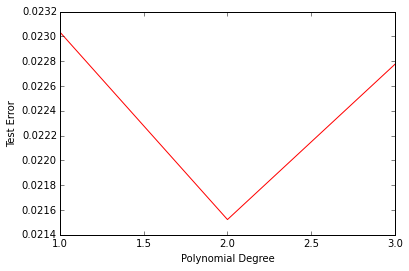

In [108]:
Y = construct_Y(clust_files,docs_without_summ)
n_folds=10
poly_degrees=[1,2,3]
find_best_order(n_folds,Y,poly_degrees)

<b> Seems the Test error is minimum when the polynomial order is 2. Raise the X_Matrix to this order and fit the Classifer</b>

In [77]:
def get_best_clf(best_order,Y,clf):
    
    poly = PolynomialFeatures(best_order)        
    
    X_Matrix = construct_X_Matrix(clust_sent_pos,clust_sent_lens,clust_mean_tfs,clust_mean_idfs,clust_mean_cfs,clust_pos_ratios,
                           clust_ner_ratio,clust_dig_ratio,clust_stop_word_ratio)
    X_Matrix = poly.fit_transform(X_Matrix)
    
    print X_Matrix
    clf.fit(X_Matrix,Y)
    print '\nFitted Regressor with best settings'
    return clf

In [78]:
clf = get_best_clf(2,Y,Ridge())

[[  1.00000000e+00   1.00000000e+00   3.20000000e+01 ...,   0.00000000e+00
    0.00000000e+00   1.18164062e-01]
 [  1.00000000e+00   9.78260870e-01   2.50000000e+01 ...,   0.00000000e+00
    0.00000000e+00   1.93600000e-01]
 [  1.00000000e+00   9.56521739e-01   2.80000000e+01 ...,   1.27551020e-03
    1.27551020e-02   1.27551020e-01]
 ..., 
 [  1.00000000e+00   3.44827586e-02   2.40000000e+01 ...,   2.77777778e-02
    7.63888889e-02   2.10069444e-01]
 [  1.00000000e+00   1.72413793e-02   3.40000000e+01 ...,   1.38408304e-02
    2.76816609e-02   5.53633218e-02]
 [  1.00000000e+00   0.00000000e+00   1.00000000e+01 ...,   1.60000000e-01
    1.20000000e-01   9.00000000e-02]]

Fitted Regressor with best settings


In [96]:
def construct_X_Matrix_for_test_doc(cluster,document,clust_sent_pos,clust_sent_lens,clust_mean_tfs,clust_mean_idfs,
                                    clust_mean_cfs,clust_pos_ratios,clust_ner_ratio,clust_dig_ratio,
                                    clust_stop_word_ratio,poly_order):
    
    '''Extract all the features for a given document and return the extracted features'''
    
    X_Matrix = []
    
    for sent_id in clust_sent_pos[cluster][document].keys():                
        
        F_position = clust_sent_pos[cluster][document][sent_id]
        F_length = clust_sent_lens[cluster][document][sent_id]
        F_mean_tfs = clust_mean_tfs[cluster][document][sent_id]
        F_mean_idfs = clust_mean_idfs[cluster][document][sent_id]
        F_mean_cfs = clust_sent_pos[cluster][document][sent_id]
        F_pos_ratio = clust_pos_ratios[cluster][document][sent_id]
        F_ner_ratio = clust_ner_ratio[cluster][document][sent_id]
        F_dig_ratio = clust_dig_ratio[cluster][document][sent_id]
        F_stop_word_ratio = clust_stop_word_ratio[cluster][document][sent_id]
        
        row = [F_position,F_length,F_mean_tfs,F_mean_idfs,F_mean_cfs,
                        F_pos_ratio,F_ner_ratio,F_dig_ratio,F_stop_word_ratio]
        
        X_Matrix.append(row)
    
    poly = PolynomialFeatures(poly_order)
    X_Matrix = poly.fit_transform(np.array(X_Matrix))
    
    return X_Matrix

In [85]:
def generate_summary(cluster,document,clf,order,i,sents_in_summ=2):
    
    '''Generate the summary for a document with sents_in_summ number of sentences in it'''
    
    X_Matrix = construct_X_Matrix_for_test_doc(cluster,document,clust_sent_pos,clust_sent_lens,clust_mean_tfs,
                                clust_mean_idfs,clust_mean_cfs,clust_pos_ratios,clust_ner_ratio,
                                clust_dig_ratio,clust_stop_word_ratio,order)
    
    y_hats = list(clf.predict(X_Matrix))    
    top_scores = sorted(y_hats,reverse=True)[0:sents_in_summ]    
    top_sentences_idxs = [y_hats.index(score) for score in top_scores]
    
    file_path = data_root_dir + '\\' + document
    doc = get_text_from_doc(file_path,txt_opn_tag,txt_close_tag)
    sentences = sent_detector.tokenize(doc)
    
    
    print '\nGENERATED SUMMARY for doc ',i, '::\n-----------------------------------'    
    summary = ''.join([sentences[idx] for idx in sorted(top_sentences_idxs)])
    print str.replace(str.replace(summary,'<P>',''),'</P>','').strip()
    print '\n'        
    
    print 'ACTUAL SUMMARY for doc ',i, '::\n-----------------------------------'    
    summary_path = data_root_dir+ '\\' + 'Summaries' + '\\' + document + '.txt'
    print extract_gold_summ_from_doc(summary_path)
    print '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
    
    '''
    print 'COMPLETE TEXT :: \n---------------------'
    complete_text = ''.join([sent for sent in sentences])
    print str.replace(str.replace(complete_text,'<P>',''),'</P>','').strip()
    '''
    

In [86]:
def random_summaries(prob):
    '''Generate summaries for approx ( (1-prob) *total_docs) number of documents
       total_docs = 300 approx.
       prob should be in the range : 0 <= prob <= 1.0 . 0 indicates all documents, 1 indicates none of the documents'''
    
    i = 1
    for clust,docs in clust_files.items():
        for doc in docs:        
            if np.random.uniform(low=0.0, high=1.0) > prob and doc not in docs_without_summ[clust] :
                generate_summary(clust,doc,clf,2,i,sents_in_summ=2)
                i += 1
                
    print 'Generation Complete'

In [87]:
random_summaries(0.98)


GENERATED SUMMARY for doc  1 ::
-----------------------------------
President Reagan appointed an interagency group to deal with the drought and Agriculture Secretary Richard Lyng authorized farmers in drought parched counties in 13 states to harvest hay on idled crop land in the government's Conservation Reserve Program.White House spokesman Marlin Fitzwater said that the president is "very concerned" about the drought, and "wants to make certain that everything that the federal government can do to assist will be done."


ACTUAL SUMMARY for doc  1 ::
-----------------------------------
The Reagan administration has moved to deal with the worsening drought by appointing an interagency group and authorizing farmers in dry counties to harvest hay on Conservation Reserve Program land. Thirteen states are now involved. A White House spokesman said the drought would drive up food prices, but not have overall implications for the economy. There was speculation that the export enhancement p

In [94]:
scale(np.array([[1,2,3],[4,5,6]])).mean(axis=0)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


array([ 0.,  0.,  0.])